# Datawrangling the pelvic floor scans
Let's see what we did there...

In [86]:
import platform
import os
import glob
import pandas
import dask
from dask.distributed import Client, LocalCluster
import dask_image.imread
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import numpy
from tqdm.auto import tqdm, trange
import imageio
# from numcodecs import Blosc
# import skimage

In [14]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})
print('Dask temporarry files go to %s' % dask.config.get('temporary_directory'))

Dask temporarry files go to /media/habi/Fast_SSD/tmp


In [15]:
# Start cluster and client now, after setting tempdir
cluster = LocalCluster()
client = Client(cluster)

/home/habi/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [16]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:34367/status"


In [17]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [18]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200

In [19]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [20]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

In [23]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research-storage-djonov')
elif 'Darwin' in platform.system():
    FastSSD = False
    BasePath = os.path.join('/Users/habi/Dev/Dea/Data')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Aaldijk')
print('We are loading all the data from %s' % Root)

We are loading all the data from /home/habi/research-storage-djonov/Aaldijk


In [24]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [25]:
def get_projectionsize(logfile):
    """How big did we set the camera?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Number Of Rows' in line:
                y = int(line.split('=')[1])
            if 'Number Of Columns' in line:
                x = int(line.split('=')[1])                
    return(x*y)

In [26]:
def get_filter(logfile):
    """Get the filter we used whole scanning from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Filter=' in line:
                whichfilter = line.split('=')[1].strip()
    return(whichfilter)

In [27]:
def get_exposuretime(logfile):
    """Get the exposure time size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Exposure' in line:
                exposuretime = int(line.split('=')[1])
    return(exposuretime)

In [28]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [29]:
def get_reconstruction_grayvalue(logfile):
    grayvalue = None
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [30]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [31]:
def get_rotationstep(logfile):
    """Get the rotation step from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Rotation Step' in line:
                rotstep = float(line.split('=')[1])
    return(rotstep)

In [32]:
def get_frameaveraging(logfile):
    """Get the frame averaging from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Averaging' in line:
                avg = line.split('=')[1]
    return(avg)

In [33]:
def get_defectpixelmasking(logfile):
    """Check the 'defect pixel masking' setting"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'defect pixel mask' in line:
                defectmask = line.split('=')[1].strip()
    return(defectmask)

In [34]:
def get_machine(logfile):
    """Get the machine we used to scan"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scanner' in line:
                machine = line.split('=')[1].strip()
    return(machine)

In [35]:
def get_scantime(logfile):
    """How long did we scan?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scan duration' in line:
                time = line.split('=')[1].strip()
    return(pandas.to_timedelta(time))

In [36]:
def get_stacks(logfile):
    """How many stacks/connected scans did we make?"""
    stacks = 1
    with open(logfile, 'r') as f:
        for line in f:
            if 'conn' in line:
                stacks = int(line.split('=')[1])
    return(stacks)

In [37]:
def get_scandate(logfile, verbose=False):
    """When did we scan the Sample?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Study Date and Time' in line:
                if verbose:
                    print('Found "date" line: %s' % line.strip())
                datestring = line.split('=')[1].strip().replace('  ', ' ')
                if verbose:
                    print('The date string is: %s' % datestring)
                date = pandas.to_datetime(datestring , format='%d %b %Y %Hh:%Mm:%Ss')
                if verbose:
                    print('Parsed to: %s' % date)
                (date)
    return(date.isoformat())

In [38]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [39]:
# # Make directory for output
# OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
# print('We are saving all the output to %s' % OutPutDir)
# os.makedirs(OutPutDir, exist_ok=True)

In [40]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [41]:
# Get *all* log files
# Sort them by time, not name
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True), key=os.path.getmtime)]

In [43]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [44]:
# Check for samples which are not yet reconstructed
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not 'TScopy' in row.Folder and not 'PR' in row.Folder:
            # If there's nothing with 'rec*' on the same level, then tell us        
            if not glob.glob(row.Folder.replace('proj', '*rec*')):
                print('- %s is missing matching reconstructions' % row.LogFile[len(Root)+1:])

In [45]:
Data['XYAlignment'] = [glob.glob(os.path.join(f, '*.csv')) for f in Data['Folder']]

In [47]:
# Check for samples which are missing the .csv-files for the XY-alignment
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not len(row.XYAlignment):
            if not any(x in row.LogFile for x in ['rectmp.log']):
                # 'rectmp.log' because we only exclude it afterwards :)
                print('- %s has *not* been X/Y aligned' % row.LogFile[len(Root)+1:])

In [48]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)        
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [49]:
# Generate us some meaningful colums
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['_'.join(l[len(Root)+1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [50]:
Data.tail()

,LogFile,Folder,XYAlignment,Sample,Scan
6,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_10pct_14d,rec
7,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_10pct_25d,rec
8,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_15pct_53d,rec
9,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_15pct_44d,rec
10,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_15pct_60d,rec


In [53]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [54]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c,row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

We have 8 folders with reconstructions


In [55]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [get_filter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [get_exposuretime(log) for log in Data['LogFile']]
Data['Scanner'] = [get_machine(log) for log in Data['LogFile']]
Data['Averaging'] = [get_frameaveraging(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [get_projectionsize(log) for log in Data['LogFile']]
Data['RotationStep'] = [get_rotationstep(log) for log in Data['LogFile']]
Data['CameraWindow'] = [round((ps ** 0.5)/100)*100  for ps in Data['ProjectionSize']]
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [get_beamhardening(log) for log in Data['LogFile']]
Data['DefectPixelMasking'] = [get_defectpixelmasking(log) for log in Data['LogFile']]
Data['Scan date'] = [get_scandate(log) for log in Data['LogFile']]
Data['Scan time'] = [get_scantime(log) for log in Data['LogFile']]
Data['Stacks'] = [get_stacks(log) for log in Data['LogFile']]

Some consistency checks

In [56]:
# Check ringremoval parameters
for machine in Data['Scanner'].unique():
    print('For the %s we have '
          'ringartefact-correction values of %s' % (machine,
                                                    Data[Data.Scanner==machine]['RingartefactCorrection'].unique()))

For the SkyScan2214 we have ringartefact-correction values of [0]


In [58]:
# Check beamhardening parameters
for scanner in Data.Scanner.unique():
    print('For the %s we have '
          'beamhardening correction values of %s' % (scanner,
                                                     Data[Data.Scanner==scanner]['BeamHardeningCorrection'].unique()))

For the SkyScan2214 we have beamhardening correction values of [0]


In [59]:
# Check defect pixel masking parameters
for scanner in Data.Scanner.unique():
    print('For the %s we have '
          'defect pixel masking values of %s' % (scanner,
                                                 Data[Data.Scanner==scanner]['DefectPixelMasking'].unique()))

For the SkyScan2214 we have defect pixel masking values of ['0']


Check and display scan times

In [63]:
Data['Scan time total'] = [ st * stk  for st, stk in zip(Data['Scan time'], Data['Stacks'])]

In [66]:
# # https://www.geeksforgeeks.org/iterating-over-rows-and-columns-in-pandas-dataframe/
# columns = list(Data)
# columns.remove('Folder') 
# columns.remove('Sample')
# columns.remove('LogFile')
# columns.remove('Reconstructions')
# columns.remove('Number of reconstructions')
# columns.remove('Grayvalue')
# columns.remove('Scan time')
# columns.remove('Scan time total')
# columns.remove('Scan date')
# print(columns)
# for col in columns:
#     print(col)
#     print(Data[col].unique())
#     print(80*'-')    

In [67]:
# Check voxel sizes (*rounded* to two after-comma values)
# If different, spit out which values
roundto = 2
if len(Data['Voxelsize'].round(roundto).unique()) > 1:
    print('We scanned all datasets with %s different voxel sizes' % len(Data['Voxelsize'].round(roundto).unique()))
    for vs in sorted(Data['Voxelsize'].round(roundto).unique()):
        print('-', vs, 'um for ', end='')
        for c, row in Data.iterrows():
            if float(vs) == round(row['Voxelsize'], roundto):
                print(os.path.join(row['Sample'], row['Scan']), end=', ')
        print('')
else:
    print('We scanned all datasets with equal voxel size, namely %s um.' % float(Data['Voxelsize'].round(roundto).unique()))

We scanned all datasets with 2 different voxel sizes
- 9.0 um for Foetus01/Becken_09um_rec, 
- 20.0 um for Foetus02/rec, Foetus02_Lugol_05pct_07d/rec, Foetus02_Lugol_10pct_14d/rec, Foetus02_Lugol_10pct_25d/rec, Foetus02_Lugol_15pct_53d/rec, Foetus02_Lugol_15pct_44d/rec, Foetus02_Lugol_15pct_60d/rec, 


In [68]:
# if len(Data['Grayvalue'].unique()) > 1:
#     print('We reconstructed the datasets with different maximum gray values, namely')
#     for gv in Data['Grayvalue'].unique():
#         print(gv, 'for Samples ', end='')
#         for c, row in Data.iterrows():
#             if float(gv) == row['Grayvalue']:
#                 print(os.path.join(row['Sample'], row['Scan']), end=', ')
#         print('')
# else:
#     print('We reconstructed all datasets with equal maximum gray value, namely %s.' % Data['Grayvalue'].unique()[0])

In [69]:
# Data[['Sample', 'Scan',
#       'Voxelsize', 'Scanner',
#       'Scan date', 'CameraWindow', 'RotationStep', 'Averaging',
#       'Scan time', 'Stacks', 'Scan time total']]

In [70]:
# Get an overview over the total scan time
# Nice output based on https://stackoverflow.com/a/8907407/323100
total_seconds = int(Data['Scan time total'].sum().total_seconds())
hours, remainder = divmod(total_seconds,60*60)
minutes, seconds = divmod(remainder,60)
print('In total, we scanned for %s hours and %s minutes)' % (hours, minutes))
for machine in Data['Scanner'].unique():
    total_seconds = int(Data[Data['Scanner'] == machine]['Scan time total'].sum().total_seconds())
    hours, remainder = divmod(total_seconds,60*60)
    minutes, seconds = divmod(remainder,60)
    print('\t - Of these, we scanned %s hours and %s minutes on the %s,'
          ' for %s scans' % (hours,
                             minutes,
                             machine,
                             len(Data[Data['Scanner'] == machine])))

In total, we scanned for 13 hours and 17 minutes)
	 - Of these, we scanned 13 hours and 17 minutes on the SkyScan2214, for 8 scans


In [71]:
Data[['Sample', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow', 'RotationStep', 'Averaging', 'Scan time', 'Stacks' ]].to_excel('Details.xlsx')

In [72]:
Data[['Sample', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow',
      'RotationStep', 'Averaging', 'Scan time', 'Stacks' ]].to_excel(os.path.join(Root,'Details.xlsx'))

In [73]:
# Sort our dataframe by scan date
# Data.sort_values(by='Scan date')

In [74]:
Data.tail()

,LogFile,Folder,XYAlignment,Sample,Scan,Reconstructions,Number of reconstructions,Voxelsize,Filter,Exposuretime,...,RotationStep,CameraWindow,Grayvalue,RingartefactCorrection,BeamHardeningCorrection,DefectPixelMasking,Scan date,Scan time,Stacks,Scan time total
3,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_10pct_14d,rec,[/home/habi/research-storage-djonov/Aaldijk/Fo...,1941,20.000477,Al 1mm,1450,...,0.10,2400,0.024670,0,0,0,2021-11-15T17:32:52,02:36:34,1,02:36:34
4,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_10pct_25d,rec,[/home/habi/research-storage-djonov/Aaldijk/Fo...,1941,20.000477,Al 1mm,1482,...,0.15,2400,0.031489,0,0,0,2021-11-26T12:25:21,01:45:19,1,01:45:19
5,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_15pct_53d,rec,[/home/habi/research-storage-djonov/Aaldijk/Fo...,1941,20.000477,Al 1mm,873,...,0.15,2400,0.040167,0,0,0,2021-12-24T11:00:51,01:17:55,1,01:17:55
6,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_15pct_44d,rec,[/home/habi/research-storage-djonov/Aaldijk/Fo...,1941,20.000477,Al 1mm,873,...,0.15,2400,0.049433,0,0,0,2021-12-15T17:27:57,01:17:31,1,01:17:31
7,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_15pct_60d,rec,[/home/habi/research-storage-djonov/Aaldijk/Fo...,1941,20.000477,Al 1mm,873,...,0.15,2400,0.045549,0,0,0,2021-12-31T10:56:23,01:17:21,1,01:17:21


In [76]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, '*_spr.bmp')))[0] for f in Data['Folder']]
Data['PreviewImage'] = [dask_image.imread.imread(pip).squeeze()
                        if pip
                        else numpy.random.random((100, 100)) for pip in Data['PreviewImagePath']]

In [54]:
# Make an approximately square overview image
# lines = 10

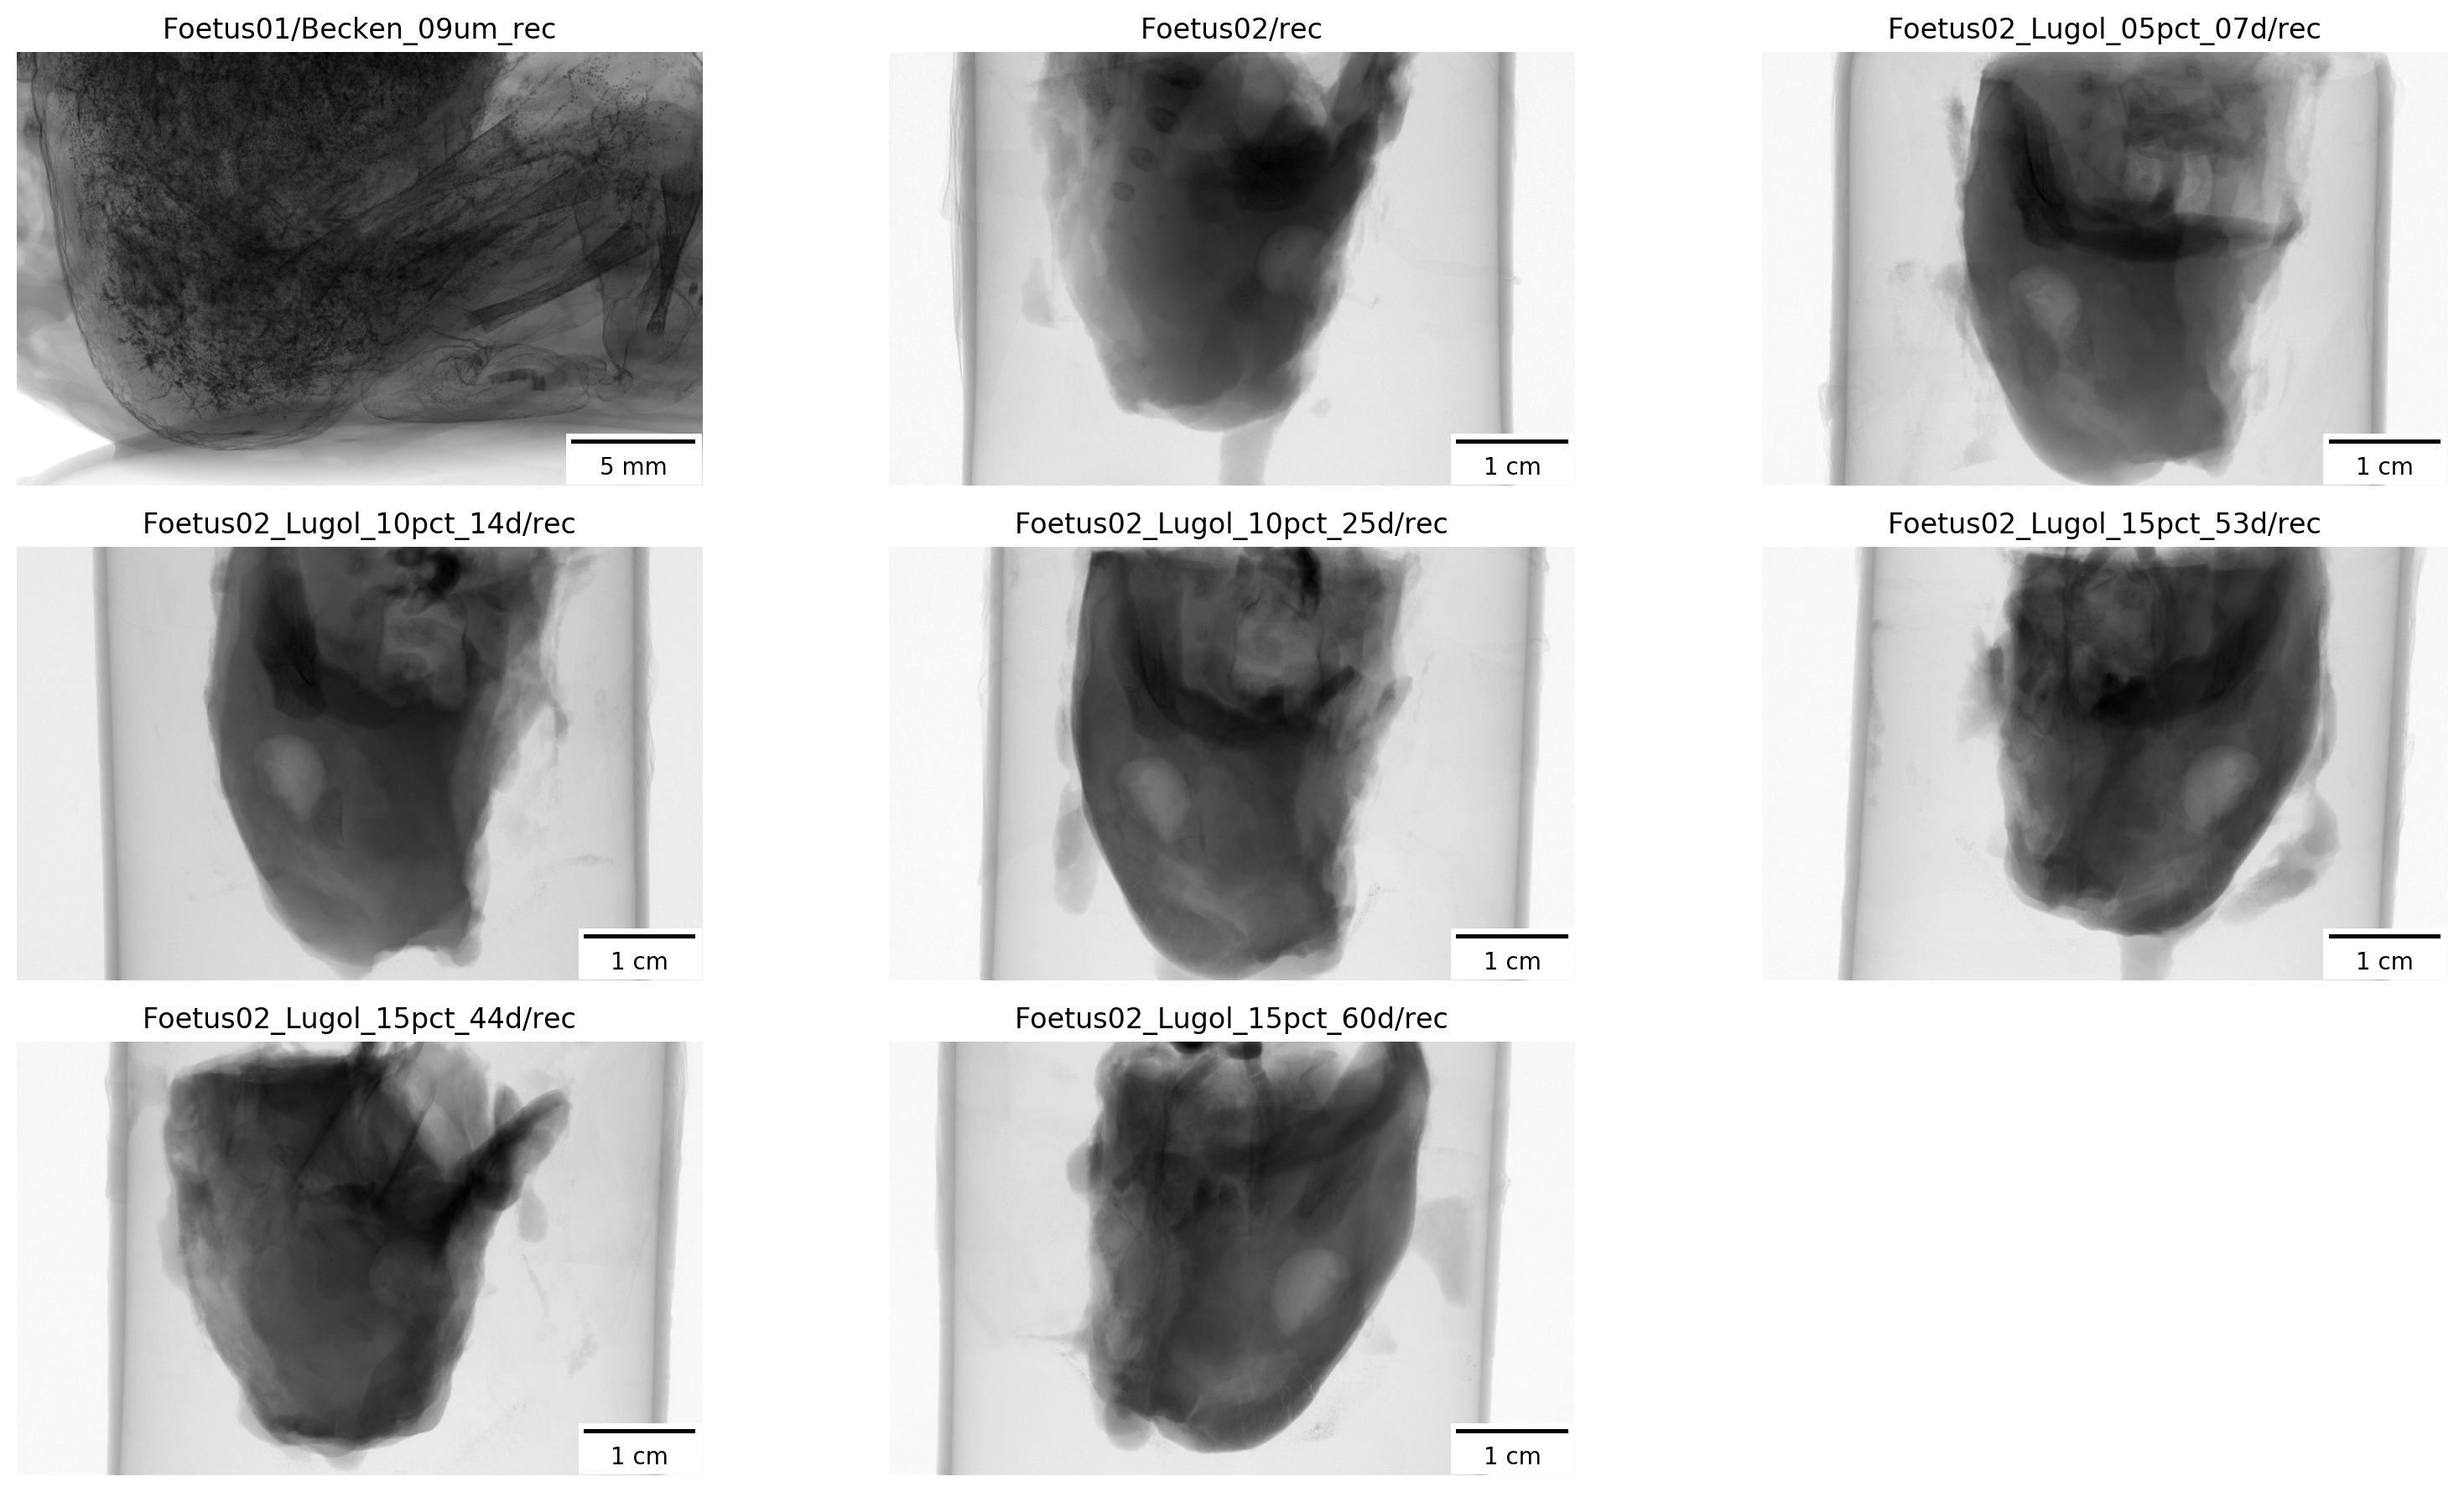

In [80]:
for c, row in Data.iterrows():
    plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
    plt.imshow(row.PreviewImage.squeeze())
    plt.title(os.path.join(row['Sample'], row['Scan']))
    plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                  'um',
                                  color='black',
                                  frameon=True))
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(Root, 'ScanOverviews.png'),
            bbox_inches='tight')
plt.show()

In [81]:
# Load all reconstructions into ephemereal DASK arrays
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

In [98]:
Data['Scan date']

0    2021-10-22T15:13:10
1    2021-10-25T18:46:14
2    2021-11-08T16:12:19
3    2021-11-15T17:32:52
4    2021-11-26T12:25:21
5    2021-12-24T11:00:51
6    2021-12-15T17:27:57
7    2021-12-31T10:56:23
Name: Scan date, dtype: object

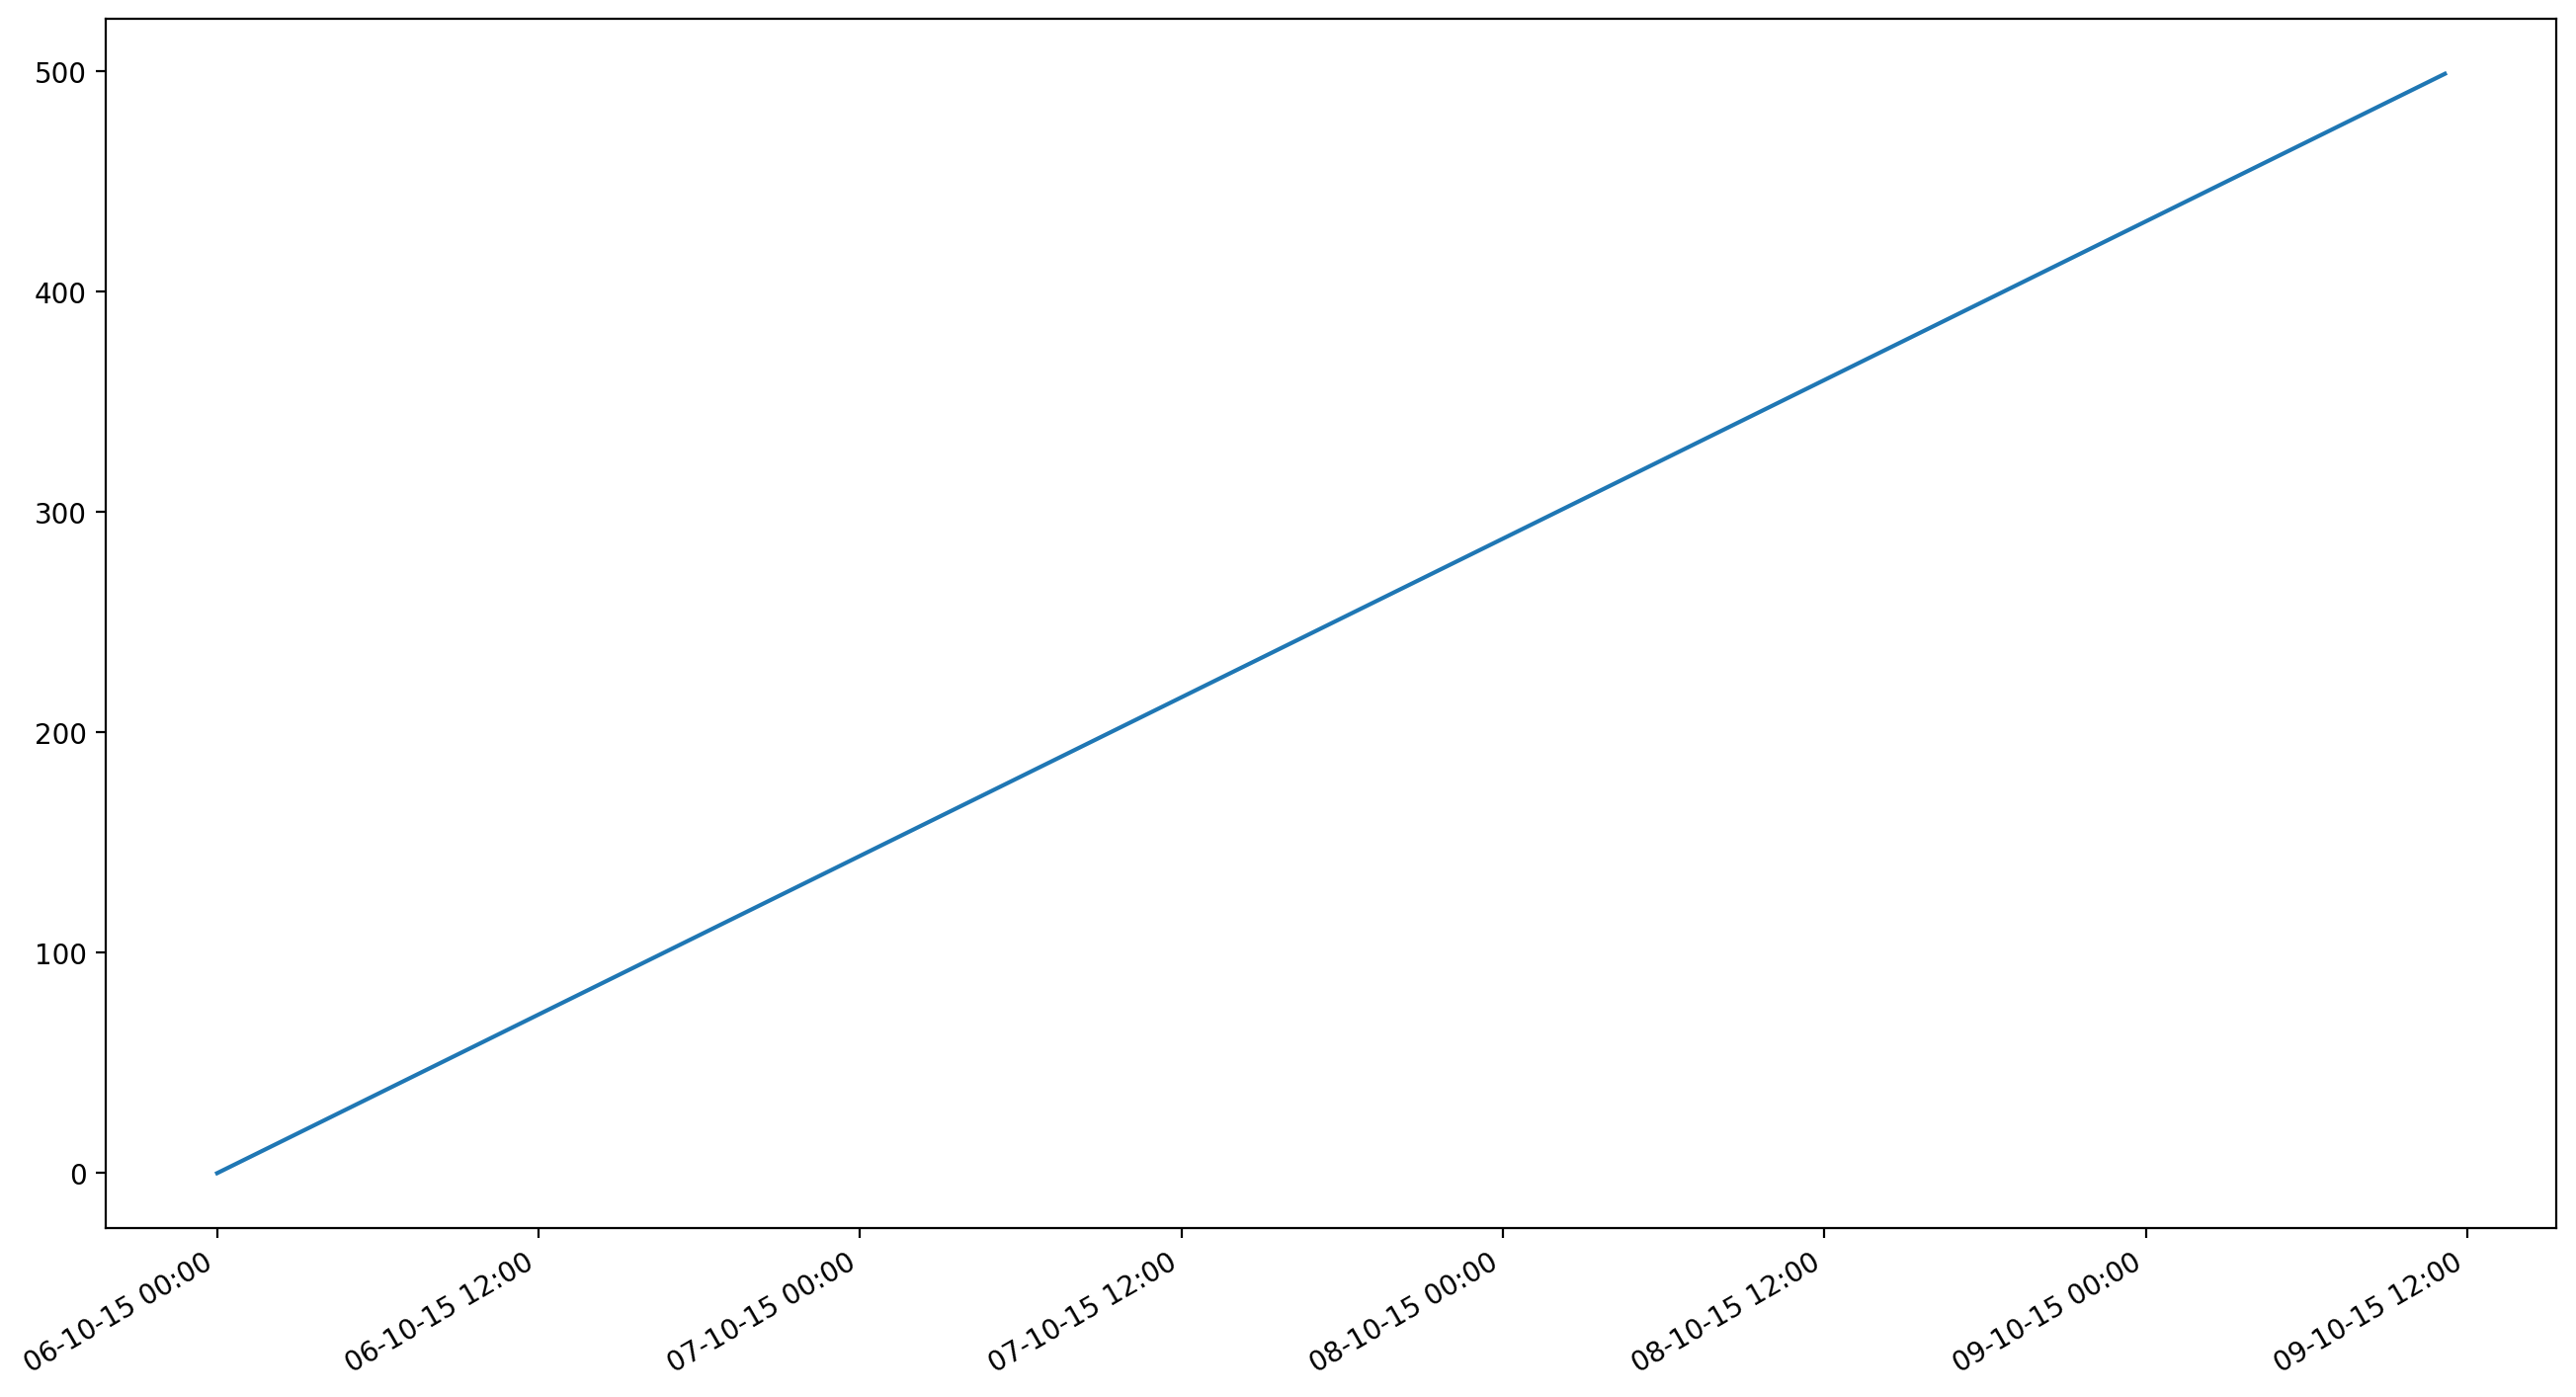

In [99]:
#https://stackoverflow.com/a/32973263/323100
import matplotlib.dates as mdates
times = pandas.date_range('2015-10-06', periods=500, freq='10min')

fig, ax = plt.subplots(1)
fig.autofmt_xdate()
plt.plot(times, range(times.size))

xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
ax.xaxis.set_major_formatter(xfmt)

plt.show()


In [108]:
Data["Scan date"]

0    2021-10-22T15:13:10
1    2021-10-25T18:46:14
2    2021-11-08T16:12:19
3    2021-11-15T17:32:52
4    2021-11-26T12:25:21
5    2021-12-24T11:00:51
6    2021-12-15T17:27:57
7    2021-12-31T10:56:23
Name: Scan date, dtype: object

In [110]:
Data.head()

,LogFile,Folder,XYAlignment,Sample,Scan,Reconstructions,Number of reconstructions,Voxelsize,Filter,Exposuretime,...,Scan time,Stacks,Scan time total,PreviewImagePath,PreviewImage,Size,Mid_Axial,Mid_Coronal,Mid_Sagittal,Time
0,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus01,Becken_09um_rec,[/home/habi/research-storage-djonov/Aaldijk/Fo...,1941,9.000117,No Filter,706,...,01:21:15,1,01:21:15,/home/habi/research-storage-djonov/Aaldijk/Foe...,"[[dask.array<getitem, shape=(), dtype=uint64, ...","(1941, 3072, 3072)","[[[dask.array<getitem, shape=(), dtype=uint64,...","[[[dask.array<getitem, shape=(), dtype=uint64,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2021-10-22 15:13:10
1,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02,rec,[/home/habi/research-storage-djonov/Aaldijk/Fo...,1893,20.000477,Al 1mm,850,...,01:51:18,1,01:51:18,/home/habi/research-storage-djonov/Aaldijk/Foe...,"[[dask.array<getitem, shape=(), dtype=uint64, ...","(1893, 2592, 2592)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 1, 3, 3, 1, 1, 3, 3, 1, 0, 0, 1, 2,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2021-10-25 18:46:14
2,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_05pct_07d,rec,[/home/habi/research-storage-djonov/Aaldijk/Fo...,1941,20.000477,Al 1mm,950,...,01:50:43,1,01:50:43,/home/habi/research-storage-djonov/Aaldijk/Foe...,"[[dask.array<getitem, shape=(), dtype=uint64, ...","(1941, 3072, 3072)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2021-11-08 16:12:19
3,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_10pct_14d,rec,[/home/habi/research-storage-djonov/Aaldijk/Fo...,1941,20.000477,Al 1mm,1450,...,02:36:34,1,02:36:34,/home/habi/research-storage-djonov/Aaldijk/Foe...,"[[dask.array<getitem, shape=(), dtype=uint64, ...","(1941, 3072, 3072)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2021-11-15 17:32:52
4,/home/habi/research-storage-djonov/Aaldijk/Foe...,/home/habi/research-storage-djonov/Aaldijk/Foe...,[],Foetus02_Lugol_10pct_25d,rec,[/home/habi/research-storage-djonov/Aaldijk/Fo...,1941,20.000477,Al 1mm,1482,...,01:45:19,1,01:45:19,/home/habi/research-storage-djonov/Aaldijk/Foe...,"[[dask.array<getitem, shape=(), dtype=uint64, ...","(1941, 3072, 3072)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",None,2021-11-26 12:25:21


In [130]:
# Data['Scan date'].plot()
Data["Time"] = pandas.to_datetime(Data['Scan date'])

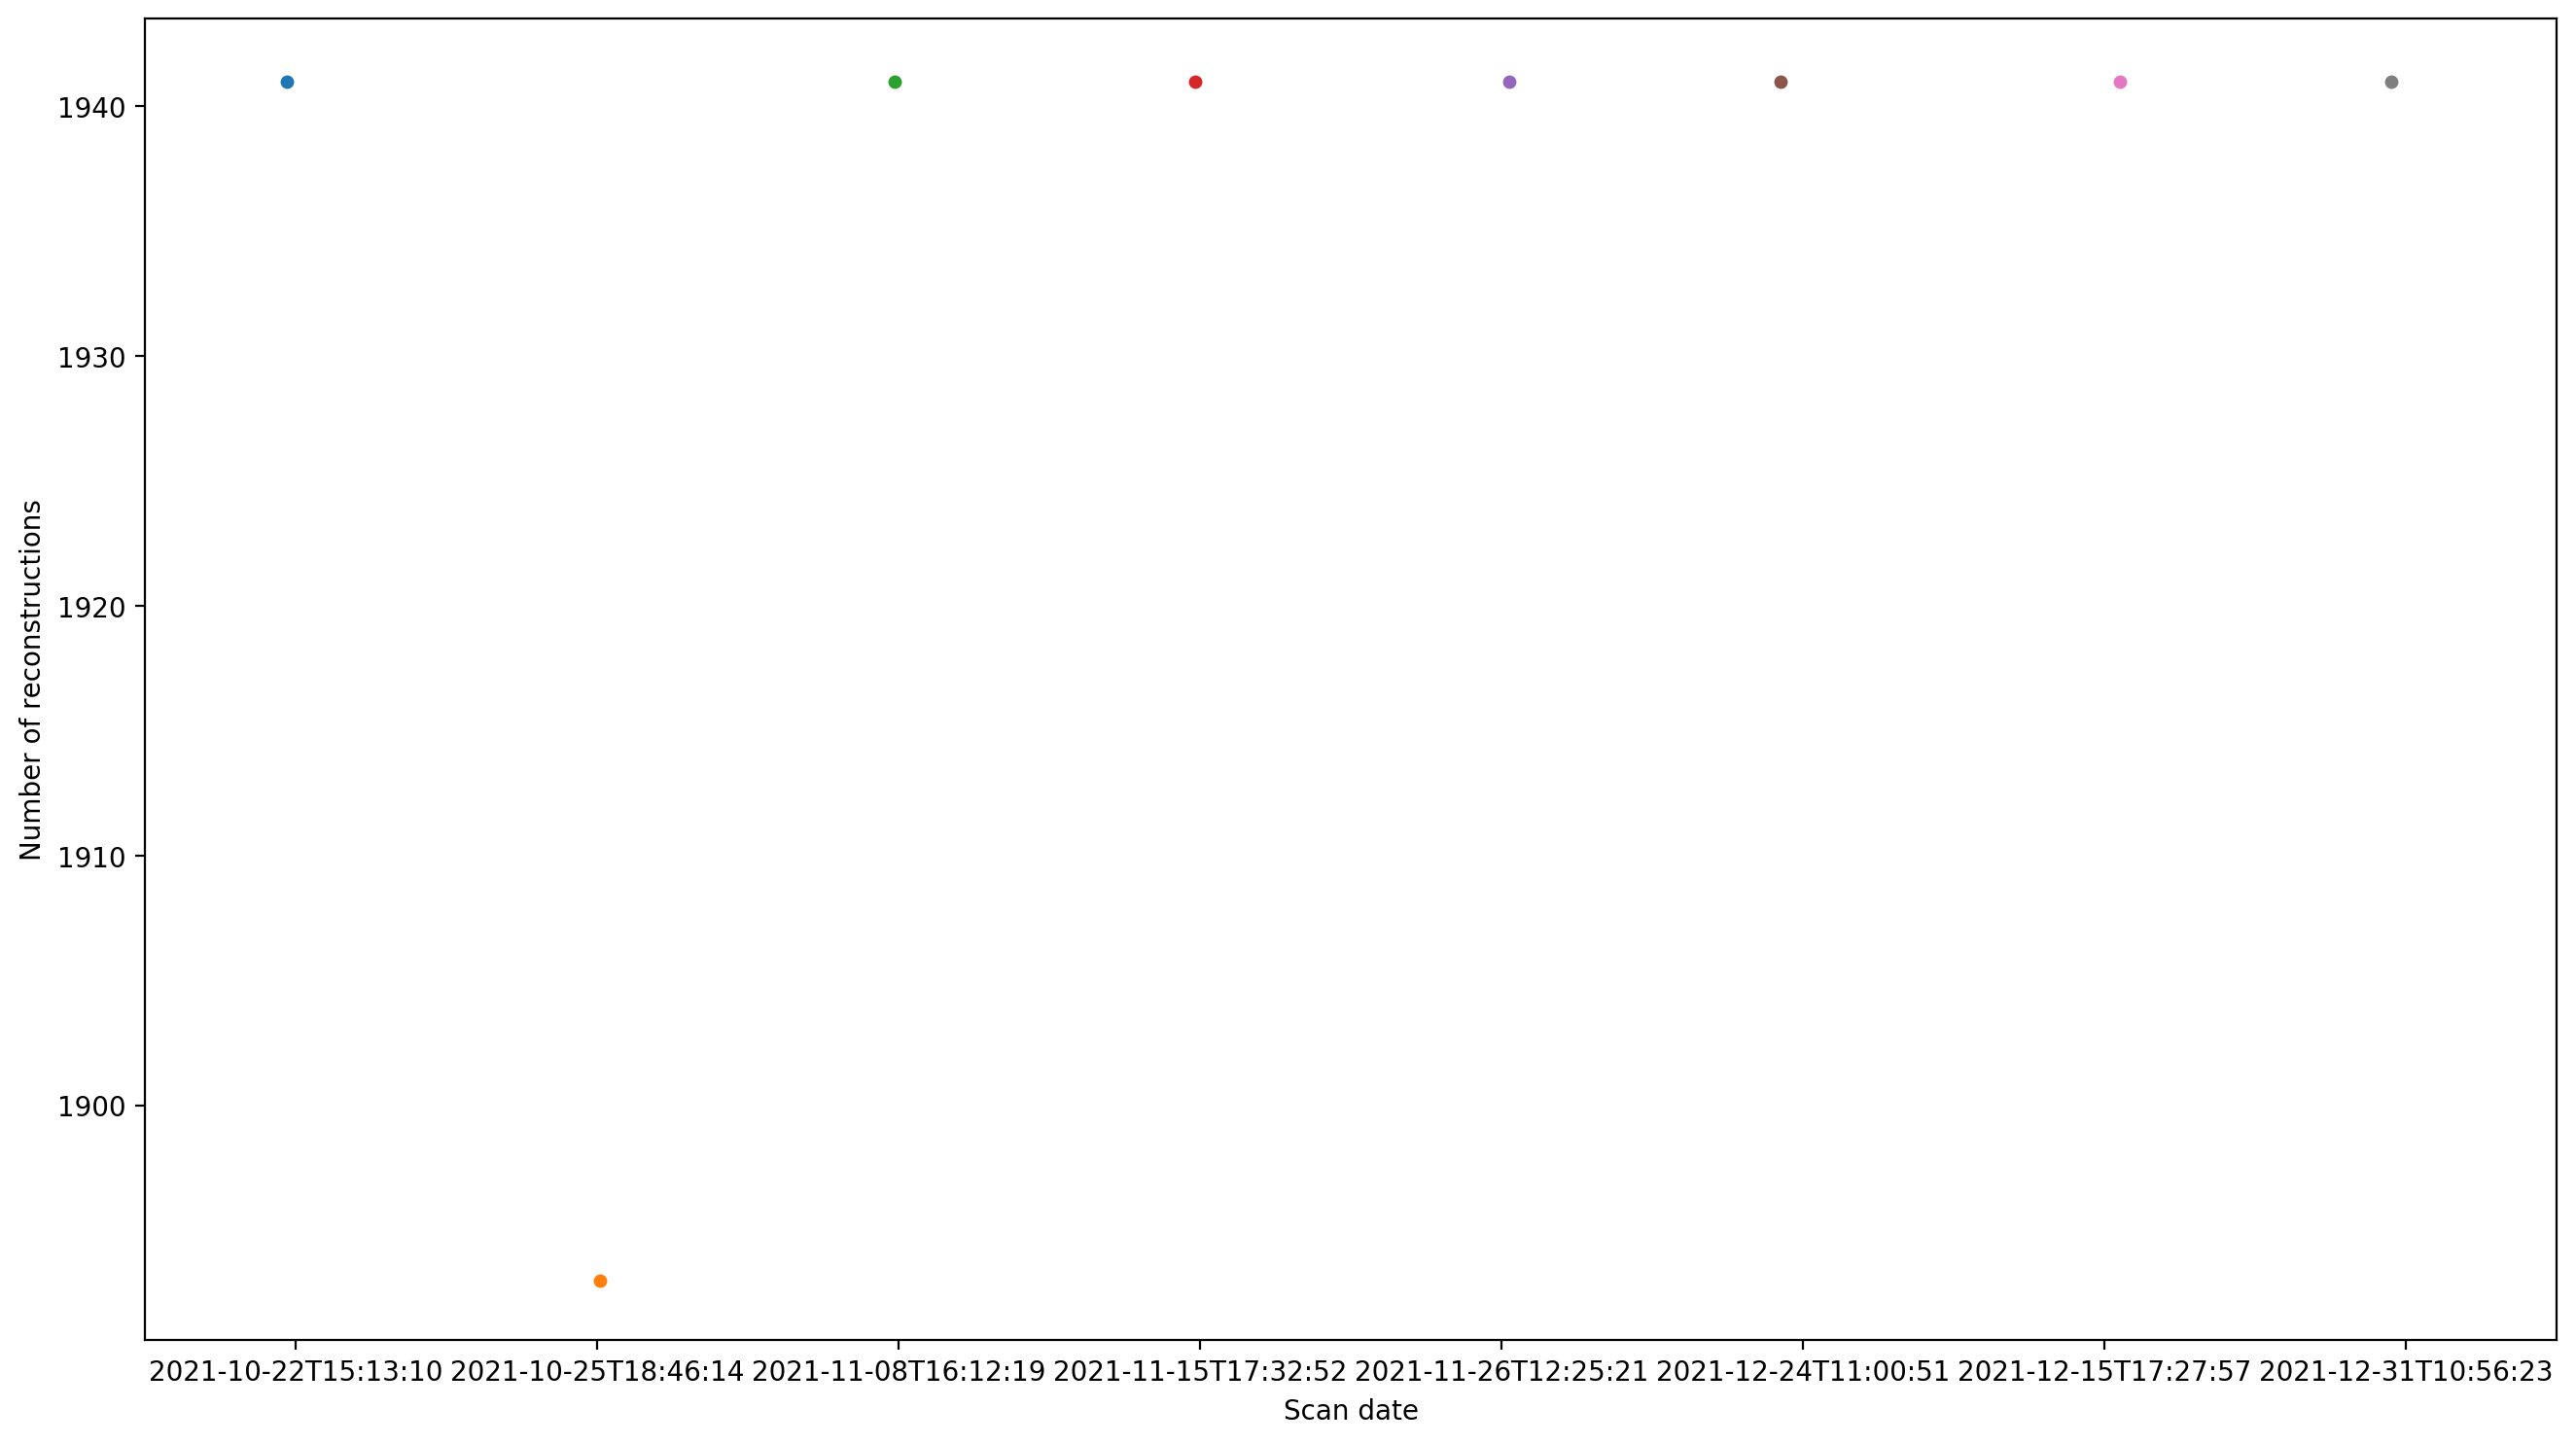

In [131]:
seaborn.stripplot(data=Data, x='Scan date', y='Number of reconstructions')
plt.show()

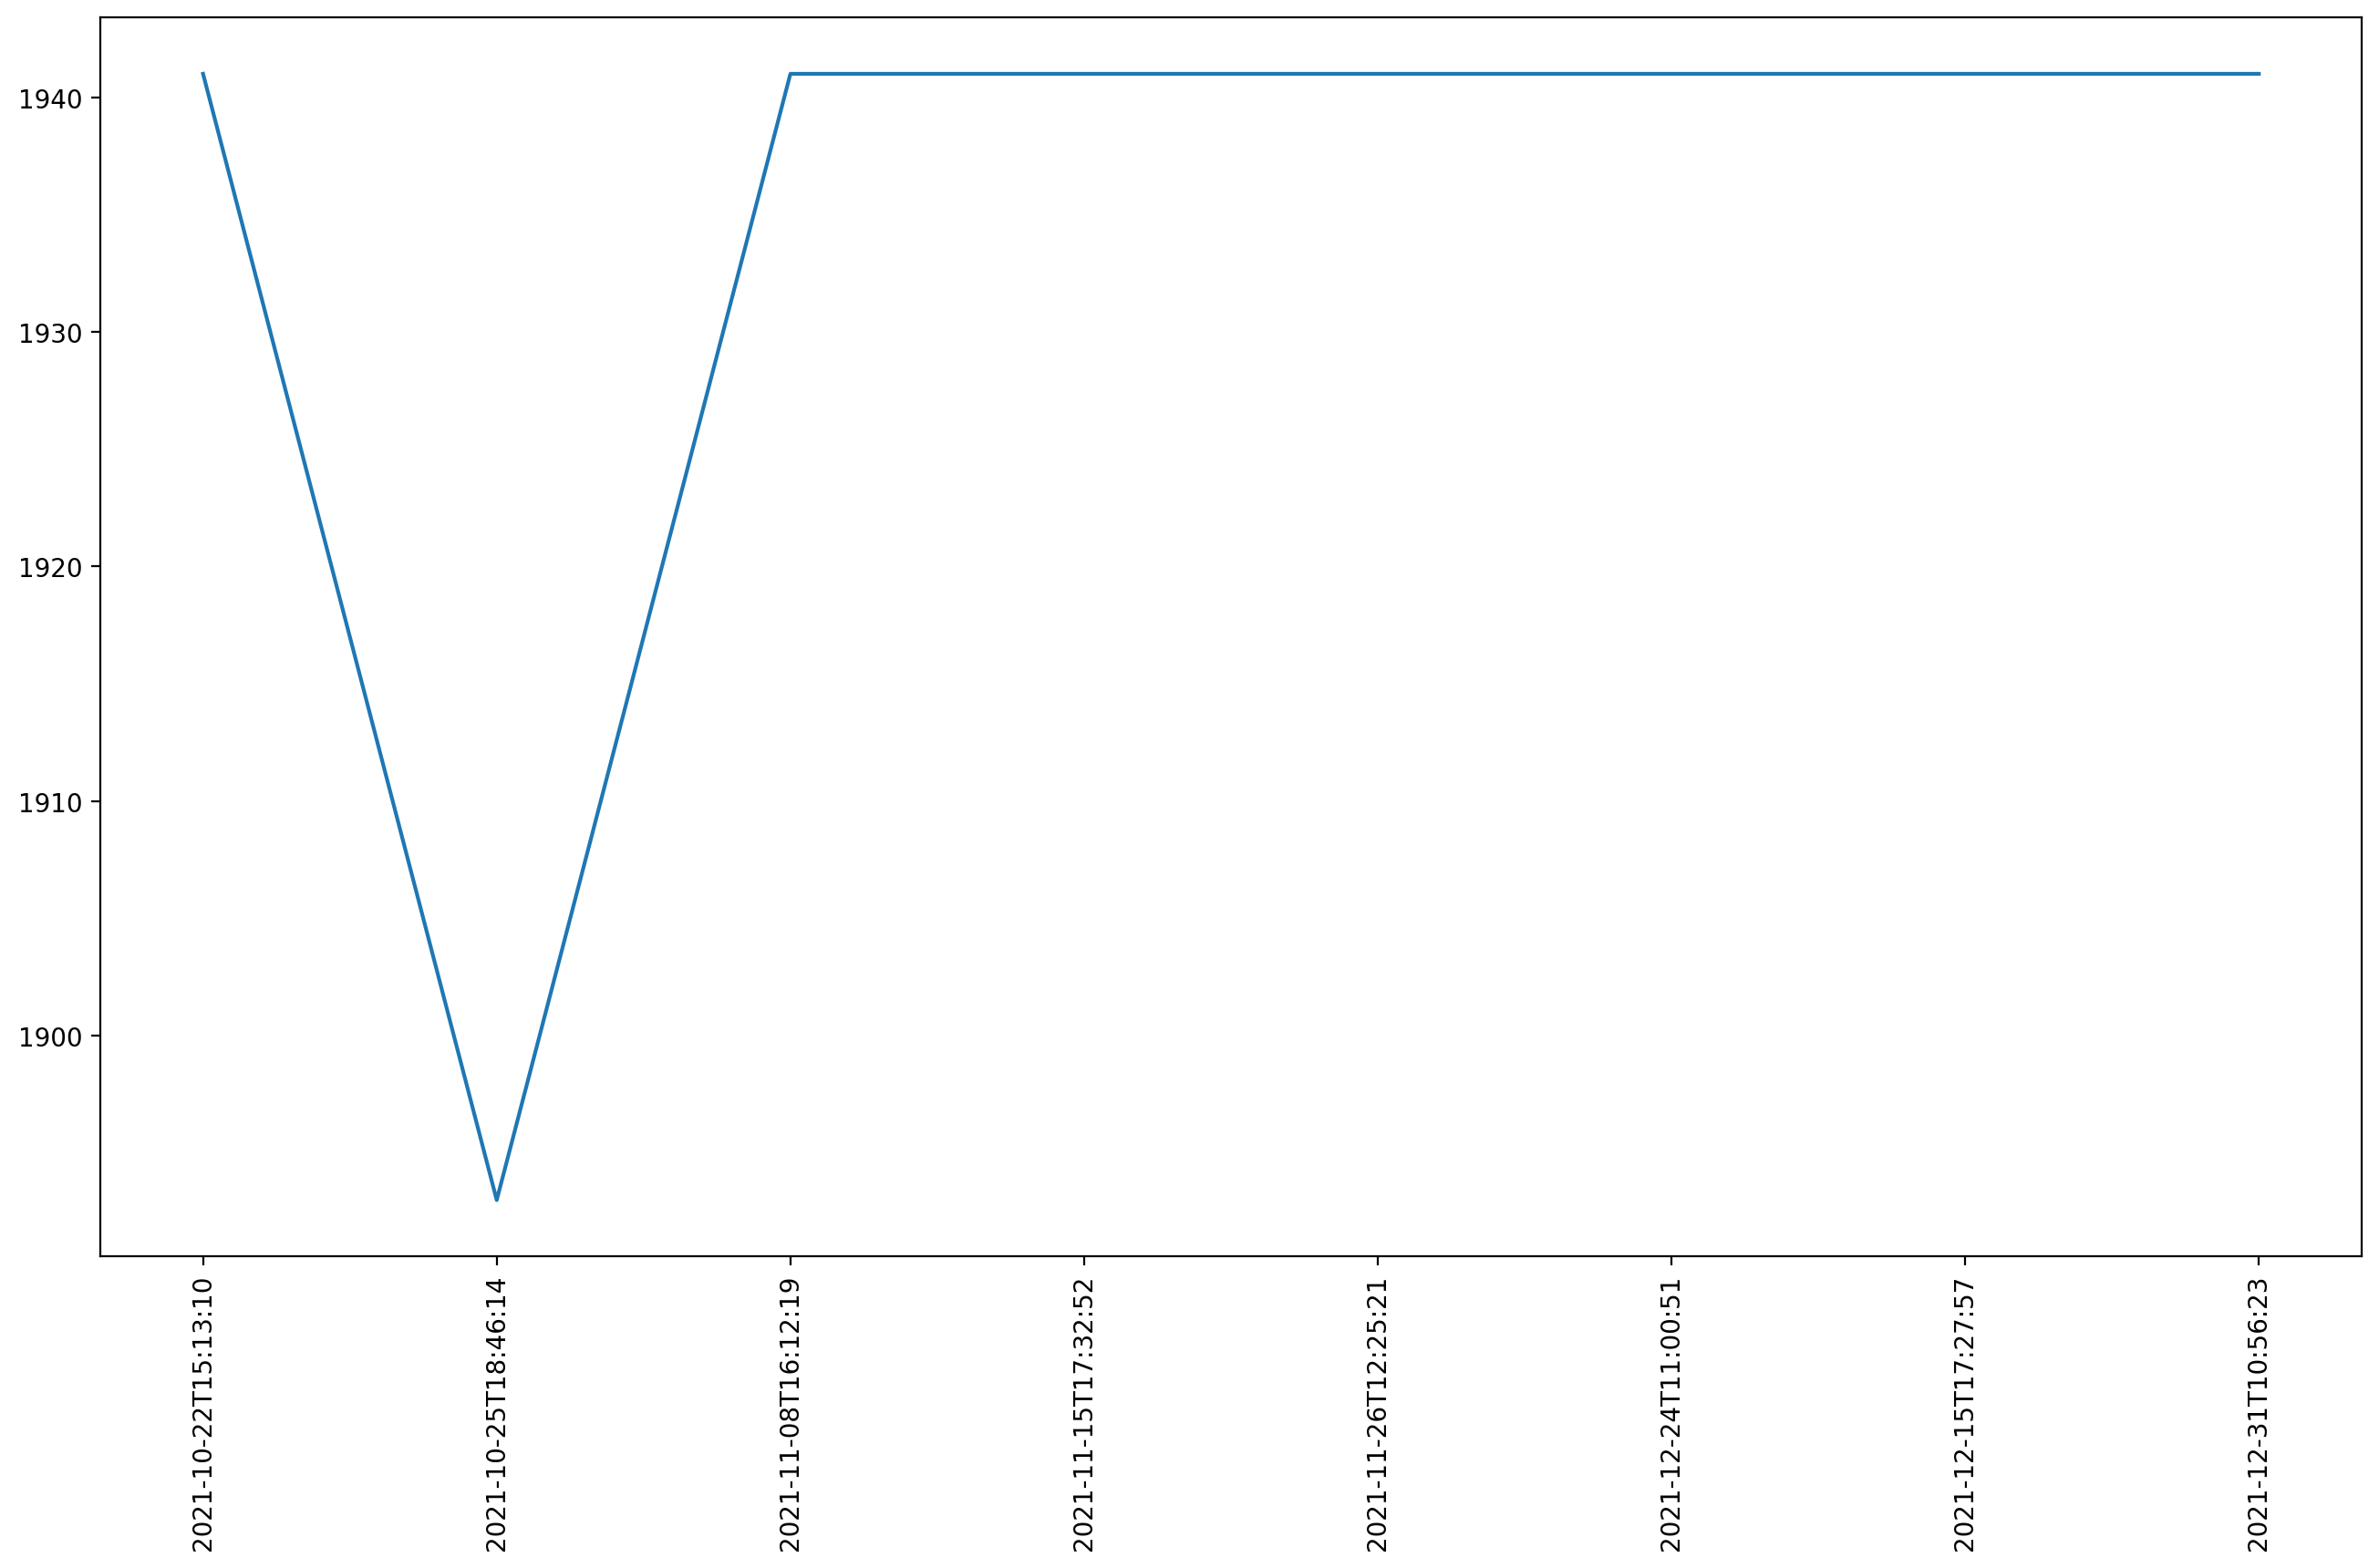

In [134]:
plt.plot(Data['Scan date'], Data['Number of reconstructions'])
plt.xticks(rotation='vertical')
plt.show()

In [135]:
# Check if something went wrong
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [136]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [137]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [138]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(), desc='Middle images', total=len(Data), leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.Middle.%s.png' % (row['Sample'],
                                                            row['Scan'],
                                                            direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = dask_image.imread.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

KeyboardInterrupt: 

In [ ]:
# Show middle slices
for c, row in tqdm(Data.iterrows(),
                   desc='Saving middle images overview',
                   total=len(Data),
                   leave=False):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MiddleSlices.png' % (row['Sample'], row['Scan']))
    if not os.path.exists(outfilepath):    
        for d, direction in tqdm(enumerate(directions),
                                 desc='%s/%s' % (row['Sample'], row['Scan']),
                                 leave=False,
                                 total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['Mid_' + direction].squeeze())
            if d == 0:
                plt.axhline(row.Size[1] // 2, c=seaborn.color_palette()[0])
                plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[2]))
            elif d == 1:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[0]))
            else:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[0])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[1]))
            plt.title('%s, %s' % (os.path.join(row['Sample'], row['Scan']),
                                  direction + ' Middle slice'))
            plt.axis('off')
            plt.savefig(outfilepath,
                        transparent=True,
                        bbox_inches='tight')
        plt.show()

In [ ]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(), desc='MIPs', total=len(Data), leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Sample'],
                                                      row['Scan'],
                                                      direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

In [ ]:
# Show MIP slices
for c, row in tqdm(Data.iterrows(),
                   desc='Saving MIP images overview',
                   total=len(Data),
                   leave=False):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Sample'], row['Scan']))
    if not os.path.exists(outfilepath):    
        for d, direction in tqdm(enumerate(directions),
                                          desc='%s/%s' % (row['Sample'], row['Scan']),
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction].squeeze())
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s, %s' % (os.path.join(row['Sample'], row['Scan']),
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath,
                    transparent=True,
                    bbox_inches='tight')
        plt.show()

In [ ]:
# Calculate the histograms of one of the MIPs
# Caveat: dask.da.histogram returns histogram AND bins, making each histogram a 'nested' list of [h, b]
Data['Histogram'] = [dask.array.histogram(dask.array.array(mip.squeeze()),
                                          bins=2**8,
                                          range=[0, 2**8]) for mip in Data['MIP_Coronal']]
# Actually compute the data and put only h into the dataframe, since we use it quite often below.
# Discard the bins
Data['Histogram'] = [h for h,b in Data['Histogram']]

In [ ]:
def overeexposecheck(item, threshold=250, howmanypercent=0.1, whichone='Coronal', verbose=False):
    '''Function to check if a certain amount of voxels are brighter than a certain value'''
    if (Data['MIP_Coronal'][item]>threshold).sum() > (Data['MIP_Coronal'][item].size * howmanypercent / 100):
        if verbose:
            plt.imshow(Data['MIP_%s' % whichone][item].squeeze())
            plt.imshow(numpy.ma.masked_equal(Data['MIP_%s' % whichone][item].squeeze()>threshold, False),
                       cmap='viridis_r',
                       alpha=.618)
            plt.title('%s/%s\n%s of %s Mpixels (>%s%%) are brigther '
                      'than %s' % (Data['Sample'][item],
                                   Data['Scan'][item],
                                   (Data['MIP_%s' % whichone][item]>threshold).sum().compute(),
                                   round(1e-6 * Data['MIP_%s' % whichone][item].size,2),
                                   howmanypercent,
                                   threshold))
            plt.axis('off')
            plt.gca().add_artist(ScaleBar(Data['Voxelsize'][item],
                                          'um'))
            plt.show()
        return(True)
    else:
        return(False)    

In [ ]:
# Check if 'too much' of the MIP is overexposed
# TODO: How much is 'too much'?
Data['OverExposed'] = [overeexposecheck(c,
                                        whichone='Axial',
                                        verbose=True) for c, row in Data.iterrows()]

In [ ]:
Data['OverExposed'].unique()

In [ ]:
for c, row in sorted(Data.iterrows()):
    plt.semilogy(row.Histogram, label='%s/%s' % (row.Sample, row.Scan))
plt.xlim([0, 255])
plt.legend()
plt.show()

In [ ]:
print('At the moment, we have previewed %s scans of %s Samples' % (len(Data), len(Data.Sample.unique())))

In [ ]:
Data.Sample

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting